# Project: Protein Data encoding and Deep Learning for Function Classification

The goal of this project will be to predict function of proteins using Deep Learning methods based on their sequence. As an intermediate step, however, you will be required to encode the protein sequence data into the vectorized form using the ProtVec model.

## Introduction
Proteins may perform various roles in organisms, with the main utility being encoded in specific fragments called active sites. Those fragments are usually conserved in the sequence and thus have been indetified and in many cases classified based on the InterPro annotation system (also called domains, with codes like IPR000000). Proteins might have multiple domains, which might also overlap, complicating the classification task.

To perform this (and many other) task, researchers have been looking for a way to efficiently and intelligently encode the protein sequence space to be lightweight, carry as much information as possible and make it possible to use in Deep Learning models. One such method developped is called ProtVec which encodes protein fragments into a vectorized form. (You should read more in the publication provided).

## Task
1. Prepare the data:
    1. Following the paper, you should prepare the data to be all the proteins from [SwissProt](https://www.uniprot.org/uniprotkb?query=reviewed:true) (Dataset is publically available as a part of the UniProt Database -- Reviewed=True).
    2. As for the classification, use the top 100 most commonly appearing InterPro domains in the SwissProt dataset. More info in tips.
2. Encode the sequential data using ProtVec model.
3. Prepare and train the ML model for protein function classification based on the prepared InterPro labels.
4. Present the results in the form of a table mapping the model accuracy to each family and summarise.

## Tips
- In the Download tool in the UniProt Database you can change the way of exporting the data, including fasta format for sequences and tsv/csv format for annotations. After selecting the tabular format you can also change the columns you want to export (ex. InterPro).
- Think how do you want to approach the multiple domains -- perform the appearance statistics on the full architecture (all domains appearing in the protein), allow model to output multiple values, follow the methods used by the authors of the ProtVec paper, treating each family separately, some other way?

Sources:
- [Continuous Distributed Representation of Biological Sequences for Deep Proteomics and Genomics](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0141287)
- [InterPro in 2022](https://academic.oup.com/nar/article/51/D1/D418/6814474?login=true)
- [UniProt: the Universal Protein Knowledgebase in 2023](https://academic.oup.com/nar/article/51/D1/D523/6835362?login=true)



## Etape 1 :

In [1]:
import pandas as pd
import numpy as np
import torch
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO
from gensim.models import Word2Vec
import re

In [2]:
sequences_file_path = "/workspace/uniprot_sprot.fasta"
interpro_file_path = "/workspace/uniprotkb_reviewed_true_2024_06_08.tsv"


def readFasta(file_path):
    names = []
    sequences = []
    sequence = ""
    with open(file_path) as file:
        for line in file.readlines():
            if line[0] == ">":
                names.append(line.split("|")[1])
                sequences.append(sequence)
                sequence = ""
            else:
                sequence += line[:-1]
        sequences.append(sequence)
        sequences.pop(0)
    return [names, sequences]


# Contient en data[0] les noms et en data[1] les séquences
data = readFasta(sequences_file_path)


"""
# POUR OBTENIR LE FICHIER INTERPRO FONCTIONS

# Contient dans la colone "Entry" les noms et dans la colone "InterPro" les codes Interpro
functions = pd.read_csv(filepath_or_buffer=interpro_file_path, sep="\t")
functions["InterPro"] = functions["InterPro"].str[:-1].str.split(pat=";")
functions.loc[functions["InterPro"].isnull(), "InterPro"] = functions.loc[
    functions["InterPro"].isnull(), "InterPro"
].apply(lambda x: ["nan"])

# On retire les InterPro qui ne sont pas des domaines
print(len(functions["InterPro"].explode()))
Interpro_type = pd.read_csv( interpro_type_file_path, sep="\t")
items_to_remove = Interpro_type[Interpro_type["ENTRY_TYPE"] != "Domain"]

functions["InterPro"] = functions["InterPro"].apply(lambda x: [item for item in x if item not in items_to_remove["ENTRY_AC"].to_list()])
print(len(functions["InterPro"].explode()))
"""


# Si vous avez le fichier functions.csv
functions = pd.read_csv("/workspace/functions.csv", converters= {"InterPro": lambda x: re.sub('[\[\]\'\" ]', '', x).split(",")})
functions["InterPro"] = functions["InterPro"].apply( lambda x : ['nan'] if x == [''] else x)
functions


# Affichage
print(data[0][:10])
print(data[1][0:2])

print()
print(functions["InterPro"])

['Q6GZX4', 'Q6GZX3', 'Q197F8', 'Q197F7', 'Q6GZX2', 'Q6GZX1', 'Q197F5', 'Q6GZX0', 'Q91G88', 'Q6GZW9']
['MAFSAEDVLKEYDRRRRMEALLLSLYYPNDRKLLDYKEWSPPRVQVECPKAPVEWNNPPSEKGLIVGHFSGIKYKGEKAQASEVDVNKMCCWVSKFKDAMRRYQGIQTCKIPGKVLSDLDAKIKAYNLTVEGVEGFVRYSRVTKQHVAAFLKELRHSKQYENVNLIHYILTDKRVDIQHLEKDLVKDFKALVESAHRMRQGHMINVKYILYQLLKKHGHGPDGPDILTVKTGSKGVLYDDSFRKIYTDLGWKFTPL', 'MSIIGATRLQNDKSDTYSAGPCYAGGCSAFTPRGTCGKDWDLGEQTCASGFCTSQPLCARIKKTQVCGLRYSSKGKDPLVSAEWDSRGAPYVRCTYDADLIDTQAQVDQFVSMFGESPSLAERYCMRGVKNTAGELVSRVSSDADPAGGWCRKWYSAHRGPDQDAALGSFCIKNPGAADCKCINRASDPVYQKVKTLHAYPDQCWYVPCAADVGELKMGTQRDTPTNCPTQVCQIVFNMLDDGSVTMDDVKNTINCDFSKYVPPPPPPKPTPPTPPTPPTPPTPPTPPTPPTPRPVHNRKVMFFVAGAVLVAILISTVRW']

0                                          [IPR000157]
1                                          [IPR006076]
2                                                [nan]
3                                          [IPR001138]
4                                                [nan]
                              ...     

In [3]:
# On transforme la colone de liste en une seule longue liste et on compte les occurences
All_InterPro_codes, counts = np.unique(
    functions["InterPro"].explode().tolist(), return_counts=True
)

# On retire le compte des NaN
nan_i = np.where(All_InterPro_codes == "nan")
All_InterPro_codes = np.delete(All_InterPro_codes, nan_i)
counts = np.delete(counts, nan_i)

# On récupère les indexes des 100 plus hauts comptes et on récupère les codes InterPro associés
values, indexes = torch.topk(torch.tensor(counts), 100)
InterPro = All_InterPro_codes[indexes]

# Affichage
print(InterPro)
print(counts[indexes])

['IPR003593' 'IPR005225' 'IPR006195' 'IPR000719' 'IPR000795' 'IPR003439'
 'IPR007197' 'IPR014001' 'IPR004161' 'IPR001650' 'IPR006073' 'IPR006638'
 'IPR000836' 'IPR017452' 'IPR003959' 'IPR002314' 'IPR000194' 'IPR004154'
 'IPR004100' 'IPR013087' 'IPR007110' 'IPR011761' 'IPR004087' 'IPR005797'
 'IPR017926' 'IPR020846' 'IPR048259' 'IPR005798' 'IPR000640' 'IPR048260'
 'IPR004821' 'IPR001048' 'IPR002048' 'IPR011545' 'IPR013155' 'IPR002942'
 'IPR004365' 'IPR001841' 'IPR001356' 'IPR003583' 'IPR003029' 'IPR002300'
 'IPR004364' 'IPR003599' 'IPR000504' 'IPR017896' 'IPR013221' 'IPR009081'
 'IPR012947' 'IPR004101' 'IPR004839' 'IPR006680' 'IPR001247' 'IPR019489'
 'IPR015590' 'IPR001623' 'IPR002792' 'IPR004044' 'IPR001750' 'IPR001279'
 'IPR015847' 'IPR003594' 'IPR001986' 'IPR004088' 'IPR000971' 'IPR015413'
 'IPR006204' 'IPR006132' 'IPR006131' 'IPR001912' 'IPR020058' 'IPR000873'
 'IPR006171' 'IPR001245' 'IPR013750' 'IPR023798' 'IPR003607' 'IPR041095'
 'IPR008909' 'IPR016180' 'IPR022669' 'IPR022666' 'I

In [4]:
functions["Chosen"] = functions["InterPro"].apply(
    lambda code_list: any(code in InterPro for code in code_list)
)
interpro_sequences = pd.DataFrame(
    list(zip(data[0], data[1])), columns=["Names", "Sequences"]
)
interpro_sequences = interpro_sequences.sort_values("Names", ignore_index=True)
interpro_sequences = interpro_sequences[functions["Chosen"] == True]
interpro_functions = functions[functions["Chosen"] == True]
interpro_sequences["InterPro"] = interpro_functions["InterPro"]
interpro_sequences

Names                                          Sequences  \
5       A0A017SEX7  MNDDPPCIVGMACRLPGDVRSPSQLWDLVINQKTGQGPTPPIRYNV...   
11      A0A017SQ41  MGSIESDSVLSFFSQRCCQNPDNTAIDDGPNGKLSYSQLDQQSSAL...   
65      A0A023PXF5  MQVLIGTKLVTEGIDIKQLMMVIMLDNRLNIIELIQGVGRLRDGGL...   
182     A0A024B7W1  MKNPKKKSGGFRIVNMLKRGVARVSPFGGLKRLPAGLLLGHGPIRM...   
185     A0A024F910  MDAPDIQAPSGSCRTTLGKVAADIFEMNVETLDWDMSFIQMGGDSI...   
...            ...                                                ...   
571581      X2JAU8  MQPPPRKGNYVKFLKNLHTEQVAKLQLKNQHECDLLEDIRQFTIKR...   
571583      X2JDY8  MGGGKNVRRGLEPLEFEECIVDSPDFRENLNRHEKELDHTSHQIKR...   
571604      X5LX76  MKYDMNHRKNSDDTPPASRTVKEMMAEFQNKLDDGDNRFRKQPPPP...   
571605      X5M5N0  MPDSITNGGRPPAPPSSVSSTTASTTGNFGTRRRLVNRIKKVDELH...   
571606      X5M8U1  MLFLRLFIFTPFLILANCQARRTIKVGLLFVQNVSSLQVGIGYRTS...   

                                                 InterPro  
5       [IPR014043, IPR013154, IPR014031, IPR014030, I...  
11                      [IPR000873, IPR001242, IPR009081]  
65                                            [IPR001650]  
182     [IPR000069, IPR001122, IPR011492, IPR027287, I...  
185     [IPR010071, IPR000873, IPR001242, IPR020806, I...  
...                                                   ...  
571581       [IPR031160, IPR001060, IPR035460, IPR001452]  
571583  [IPR004148, IPR001849, IPR047225, IPR000198, I...  
571604       [IPR000219, IPR001849, IPR000306, IPR017455]  
571605                             [IPR024678, IPR000719]  
571606       [IPR001054, IPR001828, IPR000719, IPR001245]  

[110866 rows x 3 columns]

In [ ]:
# NE PAS LANCER CETTE CELLULE SI VOUS AVEZ DEJA LE FICHIER 'interpro_sequences.fasta'

# Fonction pour stocker les séquences dans un fichier FASTA
def write_fasta(df, output_file):
    records = []
    for _, row in df.iterrows():
        name = row["Names"]
        seq = row["Sequences"]
        interpro_codes = ", ".join(row["InterPro"])
        description = f"InterPro codes: {interpro_codes}"
        record = SeqRecord(Seq(seq), id=name, description=description)
        records.append(record)

    SeqIO.write(records, output_file, "fasta")


# Appel de la fonction pour écrire le fichier FASTA
write_fasta(interpro_sequences, "interpro_sequences.fasta")

print("Les séquences ont été sauvegardées dans le fichier 'interpro_sequences.fasta'")

Les séquences ont été sauvegardées dans le fichier 'interpro_sequences.fasta'


#
## Etape 2 :

In [5]:
# Générer des 3-mers à partir d'une séquence de protéine
def generate_3mers(sequence):
    n = len(sequence)
    return [sequence[i : i + 3] for i in range(n - 2)]

In [6]:
# Générer les 3-mers pour toutes les séquences
all_3mers = [generate_3mers(seq) for seq in interpro_sequences["Sequences"]]
print(all_3mers[0])

['MND', 'NDD', 'DDP', 'DPP', 'PPC', 'PCI', 'CIV', 'IVG', 'VGM', 'GMA', 'MAC', 'ACR', 'CRL', 'RLP', 'LPG', 'PGD', 'GDV', 'DVR', 'VRS', 'RSP', 'SPS', 'PSQ', 'SQL', 'QLW', 'LWD', 'WDL', 'DLV', 'LVI', 'VIN', 'INQ', 'NQK', 'QKT', 'KTG', 'TGQ', 'GQG', 'QGP', 'GPT', 'PTP', 'TPP', 'PPI', 'PIR', 'IRY', 'RYN', 'YNV', 'NVD', 'VDG', 'DGY', 'GYY', 'YYH', 'YHP', 'HPD', 'PDG', 'DGN', 'GNR', 'NRS', 'RSG', 'SGG', 'GGI', 'GIN', 'INV', 'NVP', 'VPG', 'PGG', 'GGY', 'GYF', 'YFI', 'FIN', 'INE', 'NED', 'EDI', 'DIR', 'IRQ', 'RQF', 'QFD', 'FDN', 'DNG', 'NGF', 'GFF', 'FFG', 'FGI', 'GIN', 'INN', 'NNL', 'NLE', 'LEA', 'EAT', 'ATY', 'TYM', 'YMD', 'MDP', 'DPQ', 'PQQ', 'QQR', 'QRK', 'RKL', 'KLL', 'LLE', 'LEV', 'EVV', 'VVF', 'VFE', 'FEC', 'ECF', 'CFE', 'FES', 'EST', 'STG', 'TGA', 'GAS', 'ASM', 'SMK', 'MKS', 'KSM', 'SMS', 'MSG', 'SGS', 'GSN', 'SNT', 'NTG', 'TGV', 'GVY', 'VYV', 'YVG', 'VGN', 'GNF', 'NFS', 'FSV', 'SVD', 'VDY', 'DYQ', 'YQP', 'QPM', 'PMQ', 'MQT', 'QTR', 'TRD', 'RDA', 'DAD', 'ADY', 'DYL', 'YLH', 'LHR', 'HRY'

In [7]:
# NE PAS LANCER CETTE CELLULE SI LE FICHIER 'protvec_word2vec.model' EXISTE DEJA

# Entraîner le modèle Word2Vec sur les 3-mers
protvec_model = Word2Vec(
    sentences=all_3mers, vector_size=100, window=3, min_count=1, sg=1, workers=4
)

# Sauvegarder le modèle pour utiliser plus tard si besoin
protvec_model.save("protvec_word2vec.model")

In [32]:
# NE PAS LANCER CETTE CELLULE SI LE FICHIER 'protvec_512.model' EXISTE DEJA

protvec_512 = Word2Vec(
    sentences=all_3mers, vector_size=512, window=3, min_count=1, sg=1, workers=4
) # plus le vector_size est grand, plus l'entraînement sera précis

protvec_512.save("protvec_512.model")

**Détails :**
Ici, on a utilisé la bibliothèque `gensim` pour entraîner un modèle **Word2Vec** sur des séquences de 3-grams dérivées des séquences protéiques appartenant aux 100 premières classes d'Interpro.

**Paramètres de la fonction `Word2Vec` :**

- **sentences=all_3mers** : `all_3mers` = une liste de listes. Chaque sous-liste représente une séquence protéique segmentée en 3-grams.

- **vector_size=100** : Cette option définit la dimensionnalité des vecteurs de sortie. Ici, chaque 3-gram sera représenté par un vecteur de taille 100.

- **window=3** : La fenêtre contextuelle détermine la portée des mots de contexte considérés pour chaque mot cible lors de la formation. Une fenêtre de 3 signifie que le modèle examine 3 mots de chaque côté du mot cible pour prédire les mots de contexte.

- **min_count=1** : On ignore tous les 3-grams qui apparaissent moins de `min_count` fois dans l'ensemble de données. En définissant `min_count` à 1, on s'assure que même les 3-grams rares sont inclus dans le modèle.

- **sg=1** : cela signifie que le modèle Skip-gram est utilisé.

- **workers=4** : le nombre de threads à utiliser pour l'entraînement. Plus de threads peuvent accélérer l'entraînement, surtout avec de grands ensembles de données.

### Choisir l'un des 2 modèles de ProtVec pré-entraîné ci-dessous :

In [ ]:
# Charger le modèle ProtVec (100)
protvec_model = Word2Vec.load("protvec_word2vec.model")

In [7]:
# Charger le modèle ProtVec (512)
protvec_model = Word2Vec.load("/workspace/protvec_512.model")

### Encoder les séquences protéiques sélectionnées avec le model Protvec :

In [8]:
# Encoder une séquence de protéine -> obtenjir des représentations vectorielles des séquences
def encode_sequence(sequence, model):
    kmers = generate_3mers(sequence)
    vectors = [model.wv[kmer] for kmer in kmers if kmer in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)


# Check
seq = interpro_sequences.iloc[0]["Sequences"]
encoded_sequence = encode_sequence(seq, protvec_model)
print(encoded_sequence)
print(encoded_sequence.shape)

[-0.20119436  0.2844394   0.1637977   0.00674215  0.10554286 -0.20782527
  0.16080458  0.27466792 -0.01790899 -0.11917165 -0.06076836 -0.22196107
  0.14763221  0.11798739  0.06305145 -0.2476377  -0.11089566 -0.3923432
  0.14012705 -0.27757305  0.15174083 -0.07302156  0.20795321 -0.00385778
  0.18080129  0.03171404 -0.1254643   0.02077659 -0.31785446 -0.09222824
  0.06820463  0.08315001 -0.16056457 -0.11170532  0.11659432 -0.00790853
  0.04446315 -0.15909058  0.02008918 -0.14477193  0.01747133 -0.2443781
 -0.11384371 -0.12629956  0.17818008 -0.15494537 -0.14870562  0.21683209
 -0.02509121  0.20386979  0.09047866 -0.14202267 -0.2660188  -0.09107023
 -0.15409018  0.16051804 -0.05508754  0.00932279 -0.11968677 -0.01795266
  0.18756886  0.23449153 -0.3425764   0.10348298 -0.18526717  0.03706193
  0.00543205  0.01453723 -0.08147908  0.22521901 -0.01635879  0.09986437
  0.21954799 -0.1101453   0.10232278  0.15637979 -0.07627694 -0.19722252
 -0.09034029  0.1741838   0.05044198 -0.1407617   0.0

In [9]:
# Encoder toutes les séquences dans le DataFrame
interpro_sequences["Encoded"] = interpro_sequences["Sequences"].apply(
    lambda seq: encode_sequence(seq, protvec_model)
)

In [10]:
interpro_sequences

Names                                          Sequences  \
5       A0A017SEX7  MNDDPPCIVGMACRLPGDVRSPSQLWDLVINQKTGQGPTPPIRYNV...   
11      A0A017SQ41  MGSIESDSVLSFFSQRCCQNPDNTAIDDGPNGKLSYSQLDQQSSAL...   
65      A0A023PXF5  MQVLIGTKLVTEGIDIKQLMMVIMLDNRLNIIELIQGVGRLRDGGL...   
182     A0A024B7W1  MKNPKKKSGGFRIVNMLKRGVARVSPFGGLKRLPAGLLLGHGPIRM...   
185     A0A024F910  MDAPDIQAPSGSCRTTLGKVAADIFEMNVETLDWDMSFIQMGGDSI...   
...            ...                                                ...   
571581      X2JAU8  MQPPPRKGNYVKFLKNLHTEQVAKLQLKNQHECDLLEDIRQFTIKR...   
571583      X2JDY8  MGGGKNVRRGLEPLEFEECIVDSPDFRENLNRHEKELDHTSHQIKR...   
571604      X5LX76  MKYDMNHRKNSDDTPPASRTVKEMMAEFQNKLDDGDNRFRKQPPPP...   
571605      X5M5N0  MPDSITNGGRPPAPPSSVSSTTASTTGNFGTRRRLVNRIKKVDELH...   
571606      X5M8U1  MLFLRLFIFTPFLILANCQARRTIKVGLLFVQNVSSLQVGIGYRTS...   

                                                 InterPro  \
5       [IPR014043, IPR013154, IPR014031, IPR014030, I...   
11                      [IPR000873, IPR001242, IPR009081]   
65                                            [IPR001650]   
182     [IPR000069, IPR001122, IPR011492, IPR027287, I...   
185     [IPR010071, IPR000873, IPR001242, IPR020806, I...   
...                                                   ...   
571581       [IPR031160, IPR001060, IPR035460, IPR001452]   
571583  [IPR004148, IPR001849, IPR047225, IPR000198, I...   
571604       [IPR000219, IPR001849, IPR000306, IPR017455]   
571605                             [IPR024678, IPR000719]   
571606       [IPR001054, IPR001828, IPR000719, IPR001245]   

                                                  Encoded  
5       [-0.20119436, 0.2844394, 0.1637977, 0.00674215...  
11      [-0.18103485, 0.28977802, 0.1667015, -0.006039...  
65      [-0.122943506, 0.28466198, 0.075476885, 0.0203...  
182     [-0.15909624, 0.2570424, 0.15231717, -0.016509...  
185     [-0.19351746, 0.28893706, 0.15591004, -0.00330...  
...                                                   ...  
571581  [-0.14245124, 0.27340543, 0.14557566, 0.015146...  
571583  [-0.12530473, 0.2879958, 0.13113071, 0.0049570...  
571604  [-0.116332226, 0.28587067, 0.103800416, -0.008...  
571605  [-0.16990125, 0.3123117, 0.15268442, 0.0111513...  
571606  [-0.16087973, 0.26211947, 0.1508006, -0.000649...  

[110866 rows x 4 columns]

**Description :**

1. Extraire les séquences de protéines depuis data (qui contient les données du fichier fasta).

2. Générer des 3-mers à partir des séquences protéiques (via la fonction `generate_3mers`).

3. A l'aide de la bibliothèque `gensim`, on va former un modèle Word2Vec sur les 3-mers générés (entraînement du modèle sur les 3-mers).

4. Ensuite, on encode chaque séquence en utilisant les embeddings du modèle formé : l fonction `encode_sequence` convertit chaque 3-mer d'une séquence en son vecteur d'embedding, puis calcule la moyenne de ces vecteur pour obtenir la représentation vectorielle de la séquence entière.

Une fois qu'on aura encodé toutes les séquences de protéines en vecteurs, ces derniers seront prêts à être utilisés pour l'entraînement d'un modèle d'apprentissage automatique pour la classification des fonctions des protéines.


#
## Etape 3 :

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

### Création d'un dictionnaire pour les codes InterPro

In [12]:
# Dictionnaire mappant chaque code InterPro (clés) à un entier unique (valeurs)
interpro_dict = {code: i for i, code in enumerate(InterPro)}
print(interpro_dict)
num_classes = len(interpro_dict) # Nombre de classes total
print(num_classes)

{'IPR003593': 0, 'IPR005225': 1, 'IPR006195': 2, 'IPR000719': 3, 'IPR000795': 4, 'IPR003439': 5, 'IPR007197': 6, 'IPR014001': 7, 'IPR004161': 8, 'IPR001650': 9, 'IPR006073': 10, 'IPR006638': 11, 'IPR000836': 12, 'IPR017452': 13, 'IPR003959': 14, 'IPR002314': 15, 'IPR000194': 16, 'IPR004154': 17, 'IPR004100': 18, 'IPR013087': 19, 'IPR007110': 20, 'IPR011761': 21, 'IPR004087': 22, 'IPR005797': 23, 'IPR017926': 24, 'IPR020846': 25, 'IPR048259': 26, 'IPR005798': 27, 'IPR000640': 28, 'IPR048260': 29, 'IPR004821': 30, 'IPR001048': 31, 'IPR002048': 32, 'IPR011545': 33, 'IPR013155': 34, 'IPR002942': 35, 'IPR004365': 36, 'IPR001841': 37, 'IPR001356': 38, 'IPR003583': 39, 'IPR003029': 40, 'IPR002300': 41, 'IPR004364': 42, 'IPR003599': 43, 'IPR000504': 44, 'IPR017896': 45, 'IPR013221': 46, 'IPR009081': 47, 'IPR012947': 48, 'IPR004101': 49, 'IPR004839': 50, 'IPR006680': 51, 'IPR001247': 52, 'IPR019489': 53, 'IPR015590': 54, 'IPR001623': 55, 'IPR002792': 56, 'IPR004044': 57, 'IPR001750': 58, 'IPR00

### Extraction de la colonne "InterPro" sous forme d'une liste de listes (labels y)

In [41]:
y = interpro_sequences["InterPro"].tolist()
print(y)

[['IPR014043', 'IPR013154', 'IPR014031', 'IPR014030', 'IPR032821', 'IPR020841', 'IPR020807', 'IPR049551', 'IPR049552', 'IPR020843', 'IPR013968', 'IPR049900', 'IPR009081'], ['IPR000873', 'IPR001242', 'IPR009081'], ['IPR001650'], ['IPR000069', 'IPR001122', 'IPR011492', 'IPR027287', 'IPR026470', 'IPR011998', 'IPR001157', 'IPR000752', 'IPR000487', 'IPR001850', 'IPR000404', 'IPR001528', 'IPR046811', 'IPR002535', 'IPR047530', 'IPR000208', 'IPR014001', 'IPR001650', 'IPR026490', 'IPR049486', 'IPR007094', 'IPR002877'], ['IPR010071', 'IPR000873', 'IPR001242', 'IPR020806', 'IPR009081'], ['IPR025110', 'IPR000873'], ['IPR003593', 'IPR013525', 'IPR029481', 'IPR003439', 'IPR043926', 'IPR034001', 'IPR034003', 'IPR010929'], ['IPR003593', 'IPR011527', 'IPR003439'], ['IPR003593', 'IPR011527', 'IPR003439'], ['IPR003593', 'IPR003959', 'IPR047533'], ['IPR010071', 'IPR000873', 'IPR001242', 'IPR014031', 'IPR014030', 'IPR020841', 'IPR020806', 'IPR009081'], ['IPR047921', 'IPR001279'], ['IPR014043', 'IPR014031',

### Encoder les labels sous forme de vecteurs d'indicateurs multi-labels

In [14]:
def encode_labels(codes, num_classes, interpro_dict):
    # Cette fonction transforme une liste de codes InterPro en un vecteur d'indicateurs de longueur 100
    vec = np.zeros(num_classes)
    for code in codes:
        if code in interpro_dict:
            vec[interpro_dict[code]] = 1
    return vec

# y : la matrice des labels encodées
y = np.array([encode_labels(codes, num_classes, interpro_dict) for codes in y])
# X : contient les séquences encodées
X = np.array(interpro_sequences["Encoded"].tolist())

### Séparation des données en ensembles d'entraînement et de test

In [15]:
# 80% train ; 20% test
assert X.shape[0] == y.shape[0], "Les dimensions de X et y ne correspondent pas."
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### Conversion des données en tenseurs Pytorch

In [16]:
# Convertir les données en tenseurs PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

### Création des Dataloader pour le train et le test

In [17]:
# Création des DataLoader pour l'entraînement et le test
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

### Modèle de classification multi-labels

In [22]:
class MultiLabelProteinClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        # Appel au constructeur de la classe parente 'nn.Module'
        super(MultiLabelProteinClassifier, self).__init__()
        # 1ère couche linéaire : effectue une transformation linéaire sur les données d'entrée
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        # Couche de droptout : régularisation pr ignorer 50% des neurones pdt le train pr éviter l'overfitting
        self.dropout = nn.Dropout(0.3)
        # 2e couche linéaire
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        # 3e couche linéaire : produit les scores bruts (logits) pour chaque classe de sortie
        self.fc3 = nn.Linear(hidden_dim // 2, output_dim)

    def forward(self, x):
        # ReLU : introduit la non-linéarité dans le réseau
        x = torch.relu(self.fc1(x))
        x = self.dropout(x) # régularisation du modèle
        x = torch.relu(self.fc2(x))
        x = self.dropout(x) # régularisation du modèle
        x = self.fc3(x)
        return x


input_dim = X_train.shape[1]
hidden_dim = 512
output_dim = 100

model = MultiLabelProteinClassifier(input_dim, hidden_dim, output_dim)

### Entraînement du modèle

In [23]:
# Définition de la fonction de loss (multi-labels) et de l'optimiseur
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entraînement du modèle
num_epochs = 300
model.train()
train_losses = []

for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad() # réinitialise les gradients des params du modèle
        outputs = model(inputs)
        loss = criterion(outputs, labels) # calcule la loss
        loss.backward() # backpropagation
        optimizer.step() # update les params du modèle
        running_loss += loss.item() * inputs.size(0)

    # Loss moyenne
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.6f}")

Epoch 1/300, Loss: 0.085459
Epoch 2/300, Loss: 0.057387
Epoch 3/300, Loss: 0.047355
Epoch 4/300, Loss: 0.041108
Epoch 5/300, Loss: 0.037065
Epoch 6/300, Loss: 0.033945
Epoch 7/300, Loss: 0.031434
Epoch 8/300, Loss: 0.029625
Epoch 9/300, Loss: 0.028073
Epoch 10/300, Loss: 0.026777
Epoch 11/300, Loss: 0.025631
Epoch 12/300, Loss: 0.024640
Epoch 13/300, Loss: 0.023745
Epoch 14/300, Loss: 0.022958
Epoch 15/300, Loss: 0.022307
Epoch 16/300, Loss: 0.021743
Epoch 17/300, Loss: 0.021125
Epoch 18/300, Loss: 0.020674
Epoch 19/300, Loss: 0.020215
Epoch 20/300, Loss: 0.019899
Epoch 21/300, Loss: 0.019309
Epoch 22/300, Loss: 0.019013
Epoch 23/300, Loss: 0.018639
Epoch 24/300, Loss: 0.018372
Epoch 25/300, Loss: 0.018082
Epoch 26/300, Loss: 0.017812
Epoch 27/300, Loss: 0.017531
Epoch 28/300, Loss: 0.017306
Epoch 29/300, Loss: 0.017120
Epoch 30/300, Loss: 0.016890
Epoch 31/300, Loss: 0.016651
Epoch 32/300, Loss: 0.016473
Epoch 33/300, Loss: 0.016245
Epoch 34/300, Loss: 0.016051
Epoch 35/300, Loss: 0.0

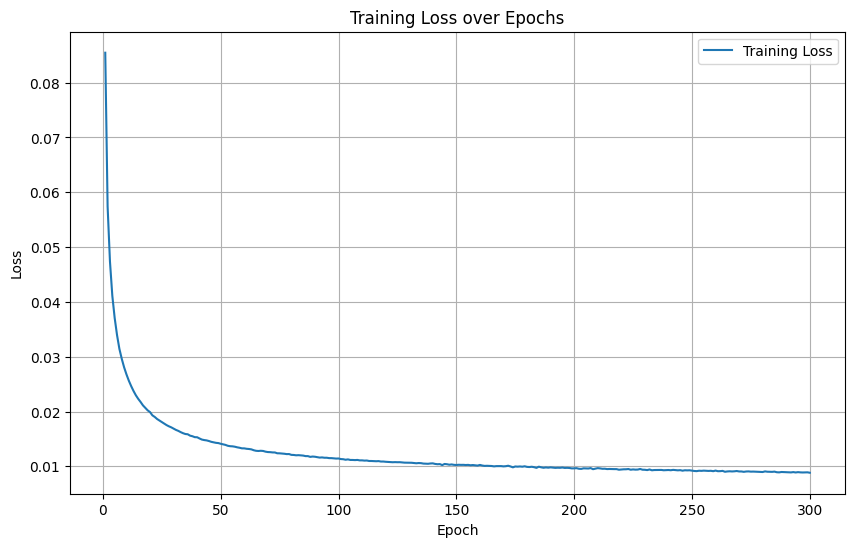

In [24]:
# Tracer la courbe de loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss")
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

### Evaluation du modèle

In [91]:
# Évaluation du modèle
def predict_labels(model, data_loader, threshold=0.5):
    model.eval()
    y_true = [] # les vrais labels
    y_pred = [] # les labels prédites

    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs) # obtenir les logits
            probabilities = torch.sigmoid(outputs)
            # On convertit les probas en labels binaires
            predicted_labels = (probabilities > threshold).int()
            y_true.extend(labels.numpy())
            y_pred.extend(predicted_labels.numpy())

    return y_true, y_pred


y_true, y_pred = predict_labels(model, test_loader)

# Calcul des scores de précision, recall et F1
precision = precision_score(y_true, y_pred, average="micro")
recall = recall_score(y_true, y_pred, average="micro")
f1 = f1_score(y_true, y_pred, average="micro")

print(
    f"Micro-average metrics\nPrecision: {precision:.4f}\nRecall: {recall:.4f}\nF1-score: {f1:.4f}"
)

# Rapport de classification
report = classification_report(y_true, y_pred, output_dict=True)
results_df = pd.DataFrame(report).transpose()

# Affichage des résultats
print("Classification Report:")
print()
print(results_df.iloc[0:21])
print(results_df.iloc[21:43])
print(results_df.iloc[43:65])
print(results_df.iloc[65:86])
print(results_df.iloc[86:100])

Micro-average metrics
Precision: 0.9526
Recall: 0.8939
F1-score: 0.9223
Classification Report:

    precision    recall  f1-score  support
0    0.926034  0.908787  0.917329   2094.0
1    0.963571  0.934858  0.948998   1443.0
2    0.952931  0.967538  0.960179   1109.0
3    0.856115  0.810443  0.832653    881.0
4    0.992602  0.974576  0.983506    826.0
5    0.949045  0.930087  0.939470    801.0
6    0.985935  0.910390  0.946658    770.0
7    0.952778  0.880616  0.915277    779.0
8    0.938144  0.955022  0.946508    667.0
9    0.914986  0.885635  0.900071    717.0
10   0.971292  0.960568  0.965900    634.0
11   0.957118  0.914754  0.935457    610.0
12   0.941634  0.913208  0.927203    530.0
13   0.982283  0.974609  0.978431    512.0
14   0.939698  0.846154  0.890476    442.0
15   0.975983  0.953092  0.964401    469.0
16   0.980507  0.969171  0.974806    519.0
17   0.957111  0.931868  0.944321    455.0
18   0.978088  0.980040  0.979063    501.0
19   0.951351  0.755365  0.842105    466.0
2

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [76]:
def accuracy_fct(y_true, y_pred):
    # Convertir les prédictions en classes binaires (0 ou 1)
    y_pred_binary = np.where(np.stack(y_pred) >= 0.5, 1, 0)
    
    # Calculer le nombre total de prédictions correctes
    correct_predictions = np.sum(y_true == y_pred_binary)
    # Accuracy = les prédictions correctes / le nombre total de prédictions
    total_predictions = y_true.size
    accuracy = correct_predictions / total_predictions
    
    return accuracy

In [77]:
accuracy = accuracy_fct(y_true, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9975


In [78]:
for i in range(100):
    accuracy = accuracy_fct(y_true[:,i], np.stack(y_pred)[:,i])
    interpro_code = list(interpro_dict.keys())[i]
    print(f"InterPro code {interpro_code}: Accuracy = {accuracy:.4f}")

InterPro code IPR003593: Accuracy = 0.9845
InterPro code IPR005225: Accuracy = 0.9935
InterPro code IPR006195: Accuracy = 0.9960
InterPro code IPR000719: Accuracy = 0.9871
InterPro code IPR000795: Accuracy = 0.9988
InterPro code IPR003439: Accuracy = 0.9957
InterPro code IPR007197: Accuracy = 0.9964
InterPro code IPR014001: Accuracy = 0.9943
InterPro code IPR004161: Accuracy = 0.9968
InterPro code IPR001650: Accuracy = 0.9936
InterPro code IPR006073: Accuracy = 0.9981
InterPro code IPR006638: Accuracy = 0.9965
InterPro code IPR000836: Accuracy = 0.9966
InterPro code IPR017452: Accuracy = 0.9990
InterPro code IPR003959: Accuracy = 0.9959
InterPro code IPR002314: Accuracy = 0.9985
InterPro code IPR000194: Accuracy = 0.9988
InterPro code IPR004154: Accuracy = 0.9977
InterPro code IPR004100: Accuracy = 0.9991
InterPro code IPR013087: Accuracy = 0.9940
InterPro code IPR007110: Accuracy = 0.9951
InterPro code IPR011761: Accuracy = 0.9958
InterPro code IPR004087: Accuracy = 0.9980
InterPro co